# Testing Evolutionary algorithms with DEAP

**S. Doncieux, Sorbonne University, 2022, [stephane.doncieux@sorbonne-universite.fr](mailto:stephane.doncieux@sorbonne-universite.fr)**

_UE Robotique et Apprentissage, Master ANDROIDE_

## Basic EA with statistics

Mostly extracted from https://deap.readthedocs.io/en/master/overview.html

The basic tournament example, but with statistics.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pickle
import numpy as np
import importlib
import random

random.seed()

from deap import base, creator, benchmarks

from deap import tools


## A simple example

In [2]:
## We create the types we need ##

# Fitness that is minimized (-1 weight)
if (hasattr(creator, "FitnessMin")):
    # Deleting any previous definition (to avoid warning message)
    del creator.FitnessMin
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

# Individual that uses this fitness
if (hasattr(creator, "Individual")):
    # Deleting any previous definition (to avoid warning message)
    del creator.Individual
creator.create("Individual", list, fitness=creator.FitnessMin)

## Tool initialization ##
IND_SIZE = 5

# toolbox is a container, each registered function can be called later on. Example:
# toolbox.register("my_function", my_great_function, default_param=42)
# toobox.my_function(...) calls my_great_function(...)
# some parameters with default values can be defined when registering the function, 
# they are then transmitted to it when it is called 
# (in the example, the param default_param is transmitted to the function with the value 42)
toolbox = base.Toolbox()

# parameters are initialized between 0 and 1
toolbox.register("attribute", random.random)

# individuals are made with IND_SIZE parameters
toolbox.register("individual", tools.initRepeat, creator.Individual,
                 toolbox.attribute, n=IND_SIZE)

# the population is a list of individuals
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def evaluate(individual):
    return sum(individual),

# 2 points crossover
toolbox.register("mate", tools.cxTwoPoint)

# gaussian mutation
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.1)

# Tournament selection: select the best out of X randomly selected individuals (with X=3)
toolbox.register("select", tools.selTournament, tournsize=3)

# Evaluation function to use
toolbox.register("evaluate", evaluate)


In [3]:
# Les statistiques permettant de récupérer les résultats
stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)


In [5]:
def main(NGEN=40, POPSIZE=10):

    # La structure qui permet de stocker les statistiques
    logbook = tools.Logbook()


    # La structure permettant de récupérer le meilleur individu
    hof = tools.HallOfFame(1)
    
    # Initialising the population
    pop = toolbox.population(n=POPSIZE)
    CXPB, MUTPB = 0.5, 0.2

    # Evaluate the entire population
    fitnesses = list(map(toolbox.evaluate, pop))
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit

    for g in range(NGEN):
        # Select the next generation individuals
        offspring = toolbox.select(pop, len(pop))
        # Clone the selected individuals
        offspring = list(map(toolbox.clone, offspring))

        # Apply crossover and mutation on the offspring
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < CXPB:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < MUTPB:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # The population is entirely replaced by the offspring
        pop[:] = offspring
        
        hof.update(pop)
        stat = stats.compile(pop)
        logbook.record(gen=g,**stat)

    return pop, hof, logbook

In [6]:
pop, hof, logbook=main(100,10)


In [7]:
print("Best=%f"%(evaluate(hof[0])[0])+" "+str(hof[0]))
print("\n")
for i,ind in enumerate(pop):
    print("Indiv[%d]=%f"%(i,evaluate(ind)[0])+" "+str(ind))


Best=-31.826702 [-4.441444135635884, -8.837389618216903, -5.321071463809686, -4.087272705527089, -9.139524397156999]


Indiv[0]=-31.099083 [-4.441444135635884, -8.837389618216903, -4.593452412910483, -4.087272705527089, -9.139524397156999]
Indiv[1]=-31.099083 [-4.441444135635884, -8.837389618216903, -4.593452412910483, -4.087272705527089, -9.139524397156999]
Indiv[2]=-31.099083 [-4.441444135635884, -8.837389618216903, -4.593452412910483, -4.087272705527089, -9.139524397156999]
Indiv[3]=-31.826702 [-4.441444135635884, -8.837389618216903, -5.321071463809686, -4.087272705527089, -9.139524397156999]
Indiv[4]=-31.099083 [-4.441444135635884, -8.837389618216903, -4.593452412910483, -4.087272705527089, -9.139524397156999]
Indiv[5]=-31.099083 [-4.441444135635884, -8.837389618216903, -4.593452412910483, -4.087272705527089, -9.139524397156999]
Indiv[6]=-31.099083 [-4.441444135635884, -8.837389618216903, -4.593452412910483, -4.087272705527089, -9.139524397156999]
Indiv[7]=-31.099083 [-4.4414441356

In [8]:
gen, min_v, avg_v, max_v=logbook.select("gen", "min", "avg", "max")



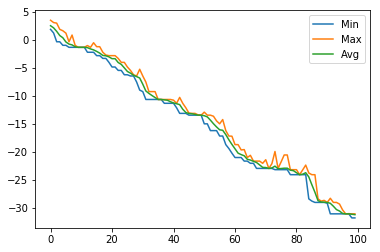

In [9]:
plt.plot(gen,min_v, label="Min")
plt.plot(gen,max_v, label="Max")
plt.plot(gen,avg_v, label="Avg")

plt.legend()

In [10]:
pop2, hof2, logbook2=main(50,10)
gen2, min_v2, avg_v2, max_v2=logbook2.select("gen", "min", "avg", "max")

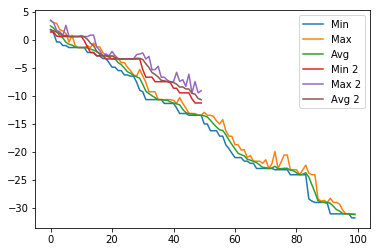

In [11]:
plt.plot(gen,min_v, label="Min")
plt.plot(gen,max_v, label="Max")
plt.plot(gen,avg_v, label="Avg")

plt.plot(gen2,min_v2, label="Min 2")
plt.plot(gen2,max_v2, label="Max 2")
plt.plot(gen2,avg_v2, label="Avg 2")

plt.legend()
plt.show()

In [12]:
NGEN=100
all_min=[[] for _ in range(NGEN)]
for i in range(10):
    popi, hofi, logbooki=main(NGEN)
    geni, min_vi, avg_vi, max_vi=logbooki.select("gen", "min", "avg", "max")
    for j in range(NGEN):
        all_min[j].append(min_vi[j])


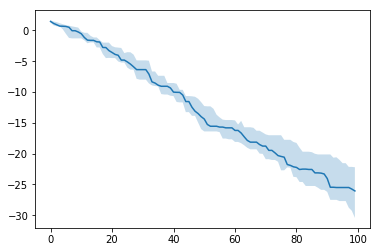

In [13]:
median_min=[np.median(all_min[i]) for i in range(len(all_min))]
q25_min=[np.quantile(all_min[i], 0.25) for i in range(len(all_min))]
q75_min=[np.quantile(all_min[i], 0.75) for i in range(len(all_min))]
plt.plot(geni,median_min)
plt.fill_between(geni, q25_min, q75_min, alpha=0.25, linewidth=0)
plt.show()